In [231]:
import sunau
from scipy.io import wavfile
from scipy import fft
import numpy
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import np_utils

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
audio_dir = "/Users/vladislao/Downloads/genres/"
test_file_1 = "blues/blues.00000.wav"
test_file_2 = "rock/rock.00000.wav"
genres = ["blues", "rock"]

In [266]:
sample_rate_1, X_1 = wavfile.read(audio_dir + test_file_1)
sample_rate_2, X_2 = wavfile.read(audio_dir + test_file_2)

In [267]:
%%capture

plt.subplot(211)

plt.specgram(X_1, Fs=sample_rate_1, xextent=(0,30))

plt.subplot(212)

plt.specgram(X_2, Fs=sample_rate_2, xextent=(0,30))

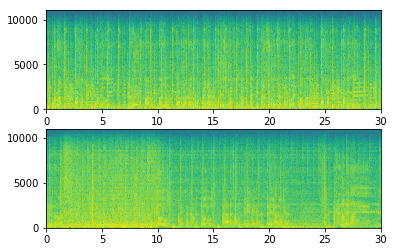

In [268]:
plt.show()

In [285]:
sqz = 5
X_1_skip = X_1.size % sqz
X_2_skip = X_2.size % sqz

X_mean_1 = numpy.reshape(X_1[X_1_skip:], (-1, sqz)).mean(axis=1)
X_mean_2 = numpy.reshape(X_2[X_2_skip:], (-1, sqz)).mean(axis=1)

X_mean_1 += 32000
X_mean_2 += 32000

X_mean_1 /= 64000
X_mean_2 /= 64000

sample_rate_sqz_1 = int(sample_rate_1 / sqz)
sample_rate_sqz_2 = int(sample_rate_2 / sqz)
print(int(sample_rate_sqz_1), X_mean_1.shape)
print(int(sample_rate_sqz_2), X_mean_2.shape)

4410 (132358,)
4410 (132358,)


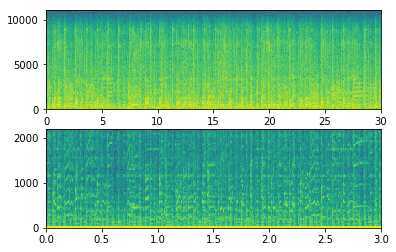

In [288]:
plt.subplot(211)
plt.specgram(X_1, Fs=sample_rate_1, xextent=(0,30))

plt.subplot(212)
plt.specgram(X_mean_1, Fs=sample_rate_1 / sqz, xextent=(0,3))

plt.show()

In [271]:
# wavfile.write(audio_dir + "blues/blues.00000.test.wav", int(sample_rate_1 / sqz), X_mean_1)

In [272]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(genres)
encoded_Y = encoder.transform(genres)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

In [274]:
window_size = int(sample_rate_sqz_1 * 0.1)
step_size = window_size - 1000
print(window_size, step_size)

2205 1205


In [278]:
X = X_mean_1
X_train_1 = numpy.array([X[start:start + window_size].reshape(-1, 1) for start in range(0, X.shape[0] - window_size, step_size)])
Y_train_1 = numpy.full((X_train_1.shape[0], 2), dummy_y[0])

# X_1 = fft(X_1)[:1000]
# X_2 = fft(X_2)[:1000]

X = X_mean_2
X_train_2 = numpy.array([X[start:start + window_size].reshape(-1, 1) for start in range(0, X.shape[0] - window_size, step_size)])
Y_train_2 = numpy.full((X_train_2.shape[0], 2), dummy_y[1])

X = numpy.append(X_train_1, X_train_2, axis=0)
Y = numpy.append(Y_train_1, Y_train_2, axis=0)

In [279]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42)

print(x_train.shape)
print(y_train.shape)

(822, 2205, 1)
(822, 2)


In [280]:
batch_size = 25
epochs = 20

In [282]:
model = Sequential()
model.add(Conv1D(32, 
                 kernel_size=5,
                 activation='relu',
                 strides=2,
                 input_shape=(window_size, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(32, 
                 3, 
                 activation='relu', 
                 strides=2
                ))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(32, 
                 3, 
                 activation='relu', 
#                  strides=2
                ))
model.add(MaxPooling1D(pool_size=2))
# ?
model.add(Flatten())
model.add(Dense(128, activation='relu'))
# model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=2,
    validation_data=(x_test, y_test),
#     callbacks=[history]
)

# plt.plot(range(1,epochs + 1), history.acc)
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.show()

Train on 822 samples, validate on 274 samples
Epoch 1/20
2s - loss: 0.6975 - acc: 0.4951 - val_loss: 0.6953 - val_acc: 0.4854
Epoch 2/20
1s - loss: 0.6934 - acc: 0.4878 - val_loss: 0.6929 - val_acc: 0.5146
Epoch 3/20
1s - loss: 0.6929 - acc: 0.5170 - val_loss: 0.6923 - val_acc: 0.5474
Epoch 4/20
1s - loss: 0.6930 - acc: 0.5280 - val_loss: 0.6939 - val_acc: 0.4854
Epoch 5/20
1s - loss: 0.6922 - acc: 0.5085 - val_loss: 0.6923 - val_acc: 0.5146
Epoch 6/20
1s - loss: 0.6942 - acc: 0.4903 - val_loss: 0.6921 - val_acc: 0.5620
Epoch 7/20
1s - loss: 0.6891 - acc: 0.5231 - val_loss: 0.6910 - val_acc: 0.5328
Epoch 8/20
1s - loss: 0.6855 - acc: 0.5706 - val_loss: 0.6970 - val_acc: 0.5146
Epoch 9/20
1s - loss: 0.6877 - acc: 0.5681 - val_loss: 0.6910 - val_acc: 0.5000
Epoch 10/20
1s - loss: 0.6760 - acc: 0.5608 - val_loss: 0.7325 - val_acc: 0.4854
Epoch 11/20
1s - loss: 0.6747 - acc: 0.5547 - val_loss: 0.6816 - val_acc: 0.5073
Epoch 12/20
1s - loss: 0.6295 - acc: 0.6204 - val_loss: 0.6449 - val_acc

In [214]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.776645805714
Test accuracy: 0.715328465848
